In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset

In [2]:
"""CHANGE THIS BEFORE EACH EXPERIMENT"""
NODE_INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_PSD/data.csv"
EDGE_INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_PEARSON/data.csv"

name = "attention_psd_pcc_transformer_2_16_32_3classes_lowlr"

MODEL_SAVE_PATH = f"./trained_models/{name}.pt"
IMAGE_SAVE_PATH = f"C:/Users/lokix/OneDrive/Documents/univsersidad/MASTER/1B/TFM/imagenes_memoria/plots/{name}.png"


In [3]:
PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED"
INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED/data.csv"

In [4]:
from entities.graphs.graph_builder import RawAndPearson, MomentsAndPearson, MomentsAndPLI, RawAndPLI, PSDAndCSD, PSDAndPearson, OfflineGeneric
from entities.graphs.data_reader import read_record

In [5]:
class BaseDataset(Dataset):
    def __init__(self, indices, builder, transform=None, target_transform=None):
        self.indices = indices
        self.builder = builder
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        current_path = self.indices.iloc[idx]["path"]
        raw_data = read_record(current_path)
        label = self.indices.iloc[idx]["label"]
        data = self.builder.build(raw_data, label)
        return data
    
class OfflineDataset(Dataset):
    def __init__(self, node_indices, edge_indices, builder, transform=None, target_transform=None):
        self.node_indices = node_indices
        self.edge_indices = edge_indices
        self.builder = builder
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.node_indices)

    def __getitem__(self, idx):
        current_path_nodes = self.node_indices.iloc[idx]["path"]
        computed_nodes = read_record(current_path_nodes)
        
        current_path_edges = self.edge_indices.iloc[idx]["path"]
        computed_edges = read_record(current_path_edges)
        
        label = self.node_indices.iloc[idx]["label"]
        data = self.builder.build(computed_nodes, computed_edges, label)
        
        return data

In [6]:
from sklearn.model_selection import train_test_split

MODE = "OFFLINE"

if MODE == "OFFLINE":

    node_indices = pd.read_csv(NODE_INDEX_PATH, index_col="Unnamed: 0")
    edge_indices = pd.read_csv(EDGE_INDEX_PATH, index_col="Unnamed: 0")

    #node_indices = node_indices.drop(node_indices[node_indices.label == "MCI"].index)
    node_indices_hc = node_indices[node_indices.label == 'HC'].sample(frac=0.7)
    node_indices_ad = node_indices[node_indices.label == 'AD']
    node_indices_mci = node_indices[node_indices.label == 'MCI'].sample(frac=0.8)
    node_indices = pd.concat([node_indices_hc, node_indices_ad, node_indices_mci])

    node_train_indices, node_test_indices = train_test_split(node_indices, shuffle=True)
    edge_train_indices, edge_test_indices = edge_indices.iloc[node_train_indices.index], edge_indices.iloc[node_test_indices.index]
    
    node_test_indices, node_val_indices = train_test_split(node_test_indices, shuffle=True)
    edge_test_indices  = edge_indices.iloc[node_test_indices.index]
    edge_val_indices = edge_indices.iloc[node_val_indices.index]

    builder = OfflineGeneric(th=None)
    
    train_dataset = OfflineDataset(node_train_indices, edge_train_indices, builder)
    test_dataset = OfflineDataset(node_test_indices, edge_test_indices, builder)
    val_dataset = OfflineDataset(node_val_indices, edge_val_indices, builder)
    
    print(len(train_dataset), len(test_dataset), len(val_dataset))
if MODE == "ONLINE":
    indices = pd.read_csv(INDEX_PATH, index_col="Unnamed: 0")
    indices = indices.drop(indices[indices.label == "MCI"].index)
    indices_hc = indices[indices.label == 'HC'].sample(frac=0.4)
    indices_ad = indices[indices.label == 'AD']
    indices = pd.concat([indices_hc, indices_ad])

    train_data, test_data = train_test_split(indices, shuffle=True)

    builder = RawAndPearson(normalize_nodes=True, normalize_edges=False, th=0)
    #builder = MomentsAndPearson(th=0)
    #builder = MomentsAndPLI()
    #builder = RawAndPLI(normalize_nodes=True, normalize_edges=False)
    #builder = PSDAndCSD()
    #builder = PSDAndPearson(th=0.5)

    train_dataset = BaseDataset(train_data, builder)
    test_dataset = BaseDataset(test_data, builder)
    train_data

8117 2029 677


In [7]:
from torch_geometric.loader import DataLoader

_BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)#sampler=weighted_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=_BATCH_SIZE, shuffle=True)

In [8]:
def check_data():
    for data in train_dataloader:
        print(data.edge_attr, data.x.shape)
        print(next(iter(data[0]))[1].shape)
        break

#check_data()


In [9]:
from entities.models.factory import ModelFactory
from entities.models.modelsTypes import Model

model_factory = ModelFactory()
# Current best: super, 16 hidden dim, 32 output dim, 2 heads -> 91% test acc best epoch, 94% train best epoch
model = model_factory.create(Model.EEGCONVNETMINIV2ATTN, attention_conv="transformer", nheads=2, hidden_dim=16, output_dim=32, nclasses=3)#, attention_conv="super", nheads=2, hidden_dim=16, output_dim=32)#, nheads=2, hidden_dim=16, output_dim=32, attention_conv="transformer", nclasses=2)
model = model.double()

In [10]:
model

EEGConvNetMiniV2Attention(
  (conv1): TransformerConv(-1, 16, heads=2)
  (conv2): TransformerConv(32, 32, heads=2)
  (conv3): TransformerConv(64, 128, heads=2)
  (batch_norm1): BatchNorm(32)
  (batch_norm2): BatchNorm(64)
  (batch_norm3): BatchNorm(256)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [11]:
criterion = torch.nn.CrossEntropyLoss()#weight=torch.tensor([3, 1], dtype=torch.float64)) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10, threshold=0.05, cooldown=0, factor=0.5, min_lr=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, verbose=True)

In [12]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from numpy import mean
import numpy as np

auroc_train_history = []
auroc_test_history = []
balACC_train_history = []

balACC_test_history = []
loss_train_history = []
loss_test_history = []

train_accs = []
test_accs = []

_NUM_EPOCHS = 300
_N_CLASSES = 3
_DEVICE = torch.device("cpu")


def train():
    model.train()
    running_loss = 0.0
    batch_loss = []
    mean_batch_loss = 0
    for i, data in enumerate(train_dataloader):  # Iterate in batches over the training dataset.

        #data.batch = data.batch.view(data.batch.shape[0], -1)
        #print(data.x[0].shape)
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.edge_attr,
                    data.batch)  # Perform a single forward pass.
        
        

        loss = criterion(out, data.label)  # Compute the loss.
        #print(loss.item())
        batch_loss.append(loss.item())
        #print(data.label)
        loss.backward()  # Derive gradients.
          # Update parameters based on gradients. 
        optimizer.step()
        
        running_loss += loss.item()
        if i%30 == 29:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 30:.3f}')
            running_loss = 0.0
            
    mean_batch_loss = mean(batch_loss)
    loss_train_history.append(mean_batch_loss)
    print(f"Training epoch {epoch}: {mean_batch_loss:.3f} loss")
    scheduler.step(mean_batch_loss)

def test(loader, compute_loss=False):
    model.eval()
    running_loss = 0
    correct = 0
    batch_loss = []
    y_probs_train = torch.empty(0, _N_CLASSES).to(_DEVICE)
    y_true_train, y_pred_train = [], []
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the training/test dataset. 
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            y_batch = data.label.to(device=_DEVICE, non_blocking=True)
            
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            
            #print(pred)
            loss = criterion(out, data.label)
            if compute_loss:
                batch_loss.append(loss.item())
            correct += int((pred == data.label).sum())  # Check against ground-truth labels.
            y_pred_train += pred.cpu().numpy().tolist()
            
            y_probs_train = torch.cat((y_probs_train, out.data), 0)
            y_true_train += y_batch.cpu().numpy().tolist()
    if compute_loss:   
        mean_batch_loss = mean(batch_loss)
        loss_test_history.append(mean_batch_loss)
    
    y_probs_train = torch.nn.functional.softmax(y_probs_train, dim=1).cpu().numpy()
    y_true_train = np.array(y_true_train)

    return correct / len(loader.dataset), y_true_train, y_probs_train, y_pred_train  # Derive ratio of correct predictions.

best_model_test_acc = 0
for epoch in range(_NUM_EPOCHS):
    train()
    
    train_acc, y_true_train, y_probs_train, y_pred_train = test(train_dataloader)
    test_acc, y_true_test, y_probs_test, y_pred_test = test(test_dataloader, compute_loss=True)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    
    balACC_train_history.append(balanced_accuracy_score(y_true_train, y_pred_train))
    balACC_test_history.append(balanced_accuracy_score(y_true_test, y_pred_test))

    print(f"Train Bal.ACC: {balACC_train_history[-1]:.3f}, test Bal.ACC: {balACC_test_history[-1]:.3f}")
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    if test_acc > best_model_test_acc: 
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("New model saved at: ", MODEL_SAVE_PATH)
        best_model_test_acc = test_acc
    #scheduler.step(test_acc)

[1,    30] loss: 1.363
[1,    60] loss: 0.942
Training epoch 0: 1.139 loss
Train Bal.ACC: 0.494, test Bal.ACC: 0.487
Epoch: 000, Train Acc: 0.5556, Test Acc: 0.5515
New model saved at:  ./trained_models/attention_psd_pcc_transformer_2_16_32_3classes_lowlr.pt
[2,    30] loss: 0.893
[2,    60] loss: 0.874
Training epoch 1: 0.881 loss
Train Bal.ACC: 0.521, test Bal.ACC: 0.519
Epoch: 001, Train Acc: 0.5922, Test Acc: 0.5939
New model saved at:  ./trained_models/attention_psd_pcc_transformer_2_16_32_3classes_lowlr.pt
[3,    30] loss: 0.861
[3,    60] loss: 0.848
Training epoch 2: 0.854 loss
Train Bal.ACC: 0.577, test Bal.ACC: 0.566
Epoch: 002, Train Acc: 0.6346, Test Acc: 0.6289
New model saved at:  ./trained_models/attention_psd_pcc_transformer_2_16_32_3classes_lowlr.pt
[4,    30] loss: 0.821
[4,    60] loss: 0.821
Training epoch 3: 0.822 loss
Train Bal.ACC: 0.574, test Bal.ACC: 0.567
Epoch: 003, Train Acc: 0.6283, Test Acc: 0.6225
[5,    30] loss: 0.823
[5,    60] loss: 0.809
Training epo

KeyboardInterrupt: 

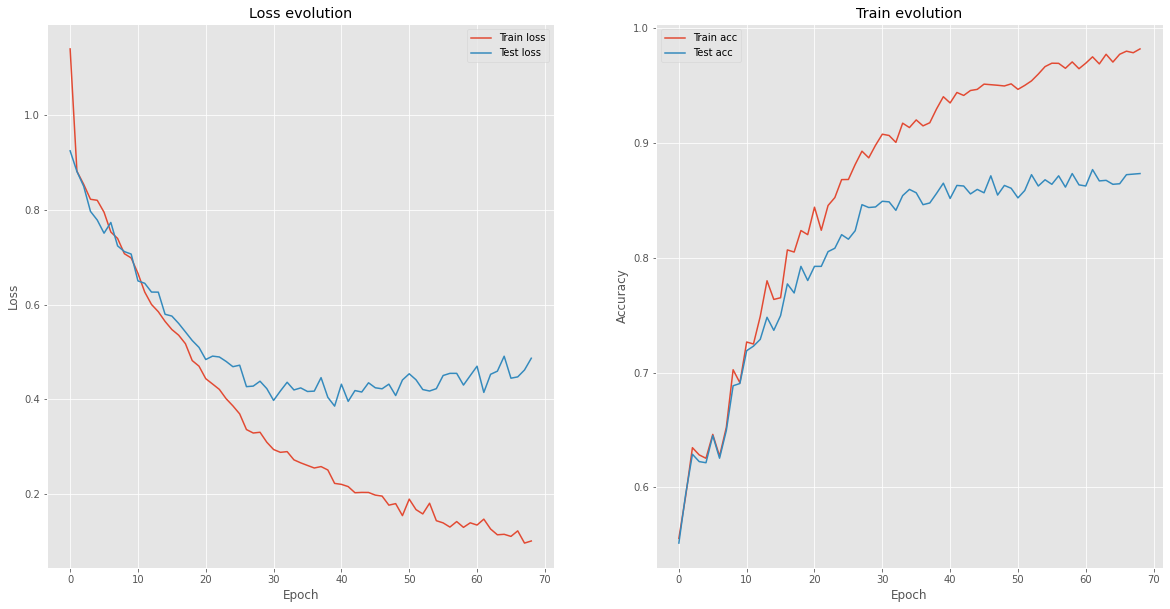

In [13]:
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(loss_train_history, label="Train loss")
plt.plot(loss_test_history, label="Test loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss evolution")

plt.subplot(122)
plt.plot(train_accs, label="Train acc")
plt.plot(test_accs, label="Test acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train evolution")
plt.savefig(IMAGE_SAVE_PATH, transparent=True)



In [14]:
model = model_factory.create(Model.EEGCONVNETMINIV2ATTN, attention_conv="transformer", nheads=2, hidden_dim=16, output_dim=32, nclasses=3)#, nheads=2, hidden_dim=16, output_dim=32, attention_conv="transformer", nclasses=2)
model = model.double()

model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

EEGConvNetMiniV2Attention(
  (conv1): TransformerConv(-1, 16, heads=2)
  (conv2): TransformerConv(32, 32, heads=2)
  (conv3): TransformerConv(64, 128, heads=2)
  (batch_norm1): BatchNorm(32)
  (batch_norm2): BatchNorm(64)
  (batch_norm3): BatchNorm(256)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [15]:
# Compute metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

def compute_metrics_binary(acc, y_true, y_probs, y_pred):
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    auc = roc_auc_score(y_true, y_probs, multi_class="ovo")#y_probs[:, 1]
    metrics = {"accuracy": acc, "bal_accuracy": bal_acc, "precision": precision, "recall": recall, "f1": f1, "auc": auc}
    return metrics

def build_latex_string(metrics):
    latex_string = ""
    splits = ["Train", "Test", "Val"]
    measures = ["accuracy", "bal_accuracy", "precision", "recall", "f1"]
    for idx, row in metrics.iterrows():
        latex_string += "\\textbf{"+splits[idx]+"}"
        for measure in measures:
            latex_string += "&"+f"{row[measure]*100:.2f}"
        latex_string += "&"+f"{row['auc']:.2f}"+"\\\\" + "\n"
    latex_string += "\\hline"
    print(latex_string)
    

train_acc, y_true_train, y_probs_train, y_pred_train = test(train_dataloader)
test_acc, y_true_test, y_probs_test, y_pred_test = test(test_dataloader)
val_acc, y_true_val, y_probs_val, y_pred_val = test(val_dataloader)

train_metrics = compute_metrics_binary(train_acc, y_true_train, y_probs_train, y_pred_train)
test_metrics = compute_metrics_binary(test_acc, y_true_test, y_probs_test, y_pred_test)
val_metrics = compute_metrics_binary(val_acc, y_true_val, y_probs_val, y_pred_val)

metrics_df = pd.DataFrame([train_metrics, test_metrics, val_metrics])
build_latex_string(metrics_df)

\textbf{Train}&97.50&97.36&97.29&97.36&97.32&1.00\\
\textbf{Test}&87.68&86.64&87.07&86.64&86.84&0.96\\
\textbf{Val}&87.59&86.69&86.60&86.69&86.63&0.97\\
\hline


In [ ]:
metrics_df


,accuracy,bal_accuracy,precision,recall,f1,auc
0,0.969958,0.968918,0.967345,0.968918,0.968119,0.995698
1,0.915751,0.912941,0.909084,0.912941,0.910916,0.970455
2,0.923077,0.918027,0.918952,0.918027,0.918484,0.973862


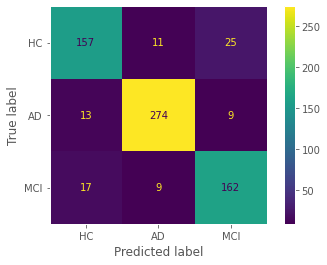

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_true_val, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "AD", "MCI"]).plot()
plt.grid(False)

plt.savefig("C:/Users/lokix/OneDrive/Documents/univsersidad/MASTER/1B/TFM/imagenes_memoria/plots/confusionmatrix.pdf", transparent=True, format="pdf")


In [31]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
from torch import nn
from torch_geometric.nn import GCNConv, BatchNorm, global_add_pool, ChebConv, global_max_pool, SAGPooling, GATConv, GATv2Conv, TransformerConv, SuperGATConv, global_mean_pool

class EEGConvNetMiniV2Attention(nn.Module):
    """Same as EEGGraphConvNet but with fewer 
    convolutional layers
    """
    def __init__(self, **kwargs):
        super(EEGConvNetMiniV2Attention, self).__init__()
        # Layers definition
        # Graph convolutional layers
        conv_layers = {
            "gatconv": GATConv,
            "gatconv2": GATv2Conv,
            "transformer": TransformerConv,
            "super": SuperGATConv
        }
        
        AttentionConv = conv_layers[kwargs.get("attention_conv", "gatconv")]
        nheads = kwargs.get("nheads", 1)
        hidden_dim = kwargs.get("hidden_dim", 32)
        output_dim = kwargs.get("output_dim", 64)
        concat = kwargs.get("concat", True)
        nclasses = kwargs.get("nclasses", 2)
        
        self.conv1 = AttentionConv(-1, hidden_dim, heads=nheads, concat=concat) #16
        self.conv2 = AttentionConv(hidden_dim * nheads, output_dim, heads=nheads, concat=concat)
        self.conv3 = AttentionConv(output_dim * nheads, output_dim * nheads * 2, heads=nheads, concat=concat)
        
        # Batch normalization
        self.batch_norm1 = BatchNorm(hidden_dim * nheads, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batch_norm2 = BatchNorm(output_dim * nheads, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batch_norm3 = BatchNorm(output_dim * nheads * 2 * nheads, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) #output_dim * nheads * 2 * 2
        
        # Fully connected layers
        self.fc1 = nn.Linear(output_dim * nheads * 2 * nheads, output_dim * nheads * 2)
        self.fc2 = nn.Linear(output_dim * nheads * 2, output_dim * nheads)
        self.fc3 = nn.Linear((output_dim * nheads), nclasses)
        
        # Xavier initializacion for fully connected layers
        self.fc1.apply(lambda x: nn.init.xavier_normal_(x.weight, gain=1) if isinstance(x, nn.Linear) else None)
        self.fc2.apply(lambda x: nn.init.xavier_normal_(x.weight, gain=1) if isinstance(x, nn.Linear) else None)
        self.fc3.apply(lambda x: nn.init.xavier_normal_(x.weight, gain=1) if isinstance(x, nn.Linear) else None)
        
        
    def forward(self, dato):
        # Perform all graph convolutions
        x = F.leaky_relu(self.batch_norm1(self.conv1(x, edge_index)), negative_slope=0.01)
        x = F.leaky_relu(self.batch_norm2(self.conv2(x, edge_index)), negative_slope=0.01)
        x = F.leaky_relu(self.batch_norm3(self.conv3(x, edge_index)), negative_slope=0.01)

        #x = F.dropout(x, p=0.2, training=self.training)
        #x = F.dropout(batch_norm_out, p=0.2, training=self.training)
        
        # Global add pooling
        mean_pool = global_add_pool(x, batch=batch)
        #print(mean_pool.size())
        
        # Apply fully connected layters
        out = F.leaky_relu(self.fc1(mean_pool), negative_slope=0.01)
        #out = F.dropout(out, p = 0.2, training=self.training)
        
        out = F.leaky_relu(self.fc2(out), negative_slope=0.01)
        #out = F.dropout(out, p = 0.2, training=self.training)
        
        out = F.leaky_relu(self.fc3(out))
        return out

In [40]:
datos = iter(train_dataloader)
datos = next(datos)
print(datos)

DataBatch(x=[2432, 6], edge_index=[2, 46208], edge_attr=[2432, 19], label=[128], batch=[2432], ptr=[129])


In [41]:
writer.add_graph(model, [datos.x, datos.edge_index, datos.edge_attr, datos.batch])
writer.close()

# Experiments

In [ ]:
PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED"
INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED/data.csv"

In [ ]:
import pandas as pd
import numpy as np
from entities.graphs.data_reader import read_record

In [ ]:
df = pd.read_csv(INDEX_PATH)
dataPath = df.iloc[828].path
dataPath2 = df.iloc[20].path
record = read_record(dataPath)
record2 = read_record(dataPath2)
#df[df["path"].str.contains("Patient_2_AD_T0_filtered_0")]

In [ ]:
from entities.graphs.node_extractors import PSDExtractor
from entities.graphs.edge_extractors import SpectralCoherenceExtractor
from scipy.signal import csd

e = SpectralCoherenceExtractor()
xd = e.extract_features(record2)
xd.shape

#a = [[np.abs(np.mean(csd(ch1, ch2, fs=256)[1])) for ch2 in record] for ch1 in record]
#a

(19, 19)

## Trying PLI implementation using Hilbert Transform

In [ ]:
from scipy.signal import hilbert
import numpy as np


hilbert_transform = np.imag(hilbert(record, axis=1))
phase_diff = np.zeros((hilbert_transform.shape[0], hilbert_transform.shape[0]))

for row in range(19):
    for col in range(19):
        phase_diff[row, col] = np.abs(np.mean(np.exp(1j*(hilbert_transform[row] - hilbert_transform[col]))))

phase_diff
#hilbert_transform

array([[1.        , 0.01680966, 0.01201729, 0.04773756, 0.05534672,
        0.04644172, 0.01285279, 0.01118647, 0.00224098, 0.01879424,
        0.03762077, 0.03050801, 0.02483143, 0.02746739, 0.06256999,
        0.02053318, 0.07664164, 0.04962734, 0.01119659],
       [0.01680966, 1.        , 0.02478112, 0.0219975 , 0.05092299,
        0.01229444, 0.01128566, 0.01451985, 0.02031599, 0.01090893,
        0.02908784, 0.04768981, 0.02741296, 0.02785296, 0.02814575,
        0.0271475 , 0.01110721, 0.03754082, 0.02911467],
       [0.01201729, 0.02478112, 1.        , 0.0339421 , 0.03705272,
        0.02274172, 0.01407025, 0.02722472, 0.043068  , 0.05775849,
        0.03813372, 0.03449887, 0.02489456, 0.03155666, 0.04380637,
        0.01369367, 0.04574425, 0.01875344, 0.0450238 ],
       [0.04773756, 0.0219975 , 0.0339421 , 1.        , 0.02585097,
        0.0143838 , 0.03085111, 0.04026279, 0.01893776, 0.03133867,
        0.04241931, 0.01446361, 0.01732261, 0.0253115 , 0.06594513,
        0.037

In [ ]:
def extract_features(data, normalize=False, th=None) -> None:

        rows, cols = data.shape
        PLImatrix = np.zeros((rows, rows))    
        
        hilbert_transform = np.imag(hilbert(data))
        
        if normalize:
            data = normalize(data)
            
        for row in range(rows):
            for col in range(rows):
                PLImatrix[row, col] = np.abs(np.mean(np.exp(1j * (hilbert_transform[row] - hilbert_transform[col]))))
          
        # Set to 0 values undes a th
        if th:
            PLImatrix = np.where(
                abs(PLImatrix) < th, 0, PLImatrix
            )
        
        # Remove self loops
        PLImatrix = np.where(
                abs(PLImatrix) == 1.0, 0, PLImatrix
            )
        
        PLImatrix = torch.from_numpy(PLImatrix)
        return PLImatrix

extract_features(record)

tensor([[0.0000, 0.0168, 0.0120, 0.0477, 0.0553, 0.0464, 0.0129, 0.0112, 0.0022,
         0.0188, 0.0376, 0.0305, 0.0248, 0.0275, 0.0626, 0.0205, 0.0766, 0.0496,
         0.0112],
        [0.0168, 0.0000, 0.0248, 0.0220, 0.0509, 0.0123, 0.0113, 0.0145, 0.0203,
         0.0109, 0.0291, 0.0477, 0.0274, 0.0279, 0.0281, 0.0271, 0.0111, 0.0375,
         0.0291],
        [0.0120, 0.0248, 0.0000, 0.0339, 0.0371, 0.0227, 0.0141, 0.0272, 0.0431,
         0.0578, 0.0381, 0.0345, 0.0249, 0.0316, 0.0438, 0.0137, 0.0457, 0.0188,
         0.0450],
        [0.0477, 0.0220, 0.0339, 0.0000, 0.0259, 0.0144, 0.0309, 0.0403, 0.0189,
         0.0313, 0.0424, 0.0145, 0.0173, 0.0253, 0.0659, 0.0375, 0.0150, 0.0285,
         0.0232],
        [0.0553, 0.0509, 0.0371, 0.0259, 0.0000, 0.0468, 0.0355, 0.0521, 0.0511,
         0.0258, 0.0687, 0.0117, 0.0265, 0.0695, 0.0260, 0.0333, 0.0063, 0.0154,
         0.0173],
        [0.0464, 0.0123, 0.0227, 0.0144, 0.0468, 0.0000, 0.0383, 0.0382, 0.0425,
         0.0654, 0.

In [ ]:
empt = np.ndarray((2, 19, 1280))
empt[0] = record
empt[1] = record2
a = spectral_connectivity_epochs(empt, method="pli", sfreq=256, mode="multitaper")
data = a.get_data()

NameError: name 'spectral_connectivity_epochs' is not defined

In [ ]:
from scipy.signal import csd

def expectation(data):
    vals = np.unique(data)
    probs = [
        np.count_nonzero(data == val) / len(data) for val in vals
    ]
    return np.sum(vals * probs)

In [ ]:
f, sxy = csd(record[0], record[2], fs=256)
expectation(np.sign(np.imag(sxy)))

In [ ]:
def _compute_pli(x, y):
    _, cpsd = csd(x, y, fs=256)
    phase_lag_index = np.mean(np.sign(np.imag(cpsd[30:60])))
    return phase_lag_index

In [ ]:

rows, cols = record.shape
PLImatrix = np.zeros((rows, rows))    
    
    
for row in range(rows):
    for col in range(rows):
        PLImatrix[row, col] = _compute_pli(record[row], record[col])


#PLImatrix = torch.from_numpy(PLImatrix)
PLImatrix

In [ ]:
from spectral_connectivity import Multitaper, Connectivity

# Compute multitaper spectral estimate
signal = np.zeros((1280, 19))
signal = np.reshape(record, (1280, 1, 19))
m = Multitaper(time_series=signal,
               sampling_frequency=256,
               start_time=0)

# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)

# Here are a couple of examples
power = c.power() # spectral power
coherence = c.coherence_magnitude()
phase_lag_index = c.phase_lag_index()
#canonical_coherence = c.canonical_coherence(brain_area_labels)

In [ ]:
print(list(c.frequencies).index(10.4))

phase_lag_index[0][10]